**UNDERSTND HOW NETWORK BUILD AND WORK**

**Import TensorFlow and other libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from keras.models import load_model

2024-05-16 13:12:37.307695: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = pathlib.Path("./flower_photos")
data_dir

PosixPath('flower_photos')

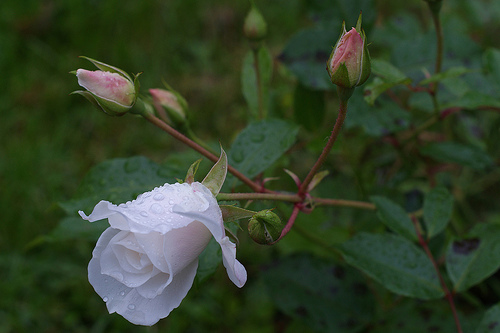

In [3]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[145]))

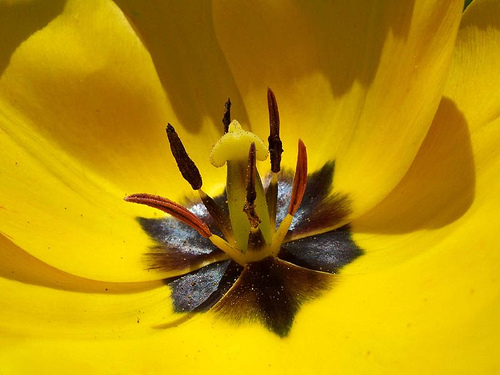

In [4]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[8]))

**Load data using a Keras utility**

In [5]:
batch_size = 32
img_height = 180
img_width = 180

# **DATA VALIDATION**
Let's use 80% of the images for training, and 20% for validation.


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2024-05-16 13:13:02.175513: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 13:13:02.180908: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the **class names** in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

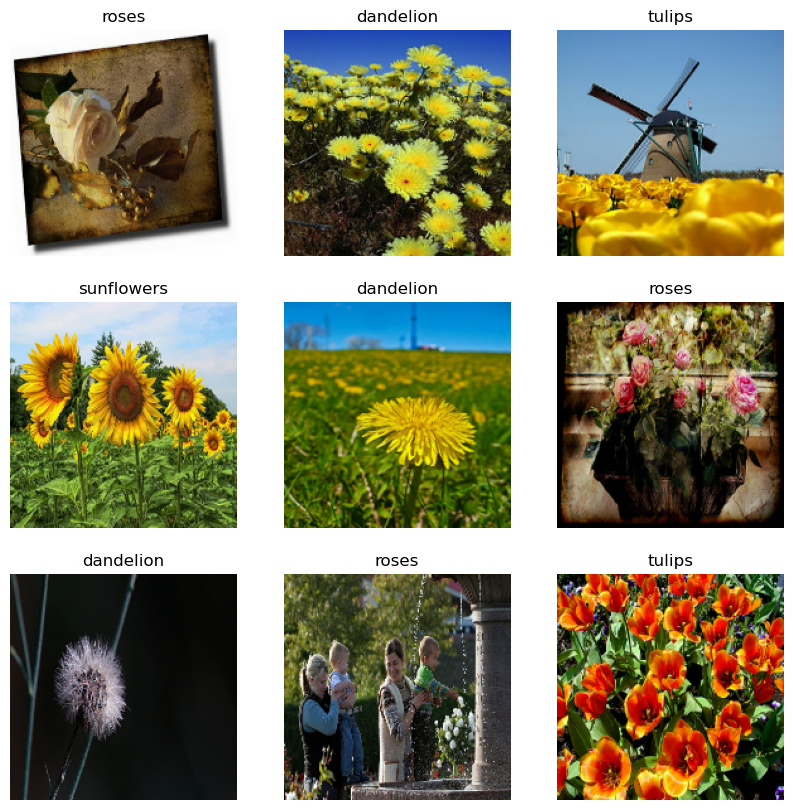

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

**Image batches**

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# **Configure the dataset for performance**

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Standardize the data**
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [12]:
normalization_layer = layers.Rescaling(1./255)
print(normalization_layer)

**Normalize data**

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## **Create the model**

The Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## **Compile the model**
tf.keras.optimizers.Adam optimizer and tf.keras.losses.SparseCategoricalCrossentropy loss function. To view training and validation accuracy for each training epoch, pass the metrics argument to Model.compile.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## **Model summary**

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## **Train the model**

In [17]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 48s 509ms/step - loss: 1.2881 - accuracy: 0.4489 - val_loss: 1.1129 - val_accuracy: 0.5490
Epoch 2/30
92/92 [==============================] - 61s 659ms/step - loss: 0.9621 - accuracy: 0.6267 - val_loss: 0.9675 - val_accuracy: 0.6158
Epoch 3/30
92/92 [==============================] - 62s 679ms/step - loss: 0.8114 - accuracy: 0.6948 - val_loss: 0.8958 - val_accuracy: 0.6362
Epoch 4/30
92/92 [==============================] - 62s 679ms/step - loss: 0.6499 - accuracy: 0.7623 - val_loss: 0.8833 - val_accuracy: 0.6553
Epoch 5/30
92/92 [==============================] - 65s 708ms/step - loss: 0.4493 - accuracy: 0.8392 - val_loss: 1.0066 - val_accuracy: 0.6512
Epoch 6/30
92/92 [==============================] - 49s 531ms/step - loss: 0.2827 - accuracy: 0.8968 - val_loss: 0.9874 - val_accuracy: 0.6771
Epoch 7/30
92/92 [==============================] - 53s 578ms/step - loss: 0.1573 - accuracy: 0.9527 - val_loss: 1.3097 - val_accuracy: 0.6444

In [18]:
model_name = 'flower.h5'
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at flower.h5 


## **Visualize training results**

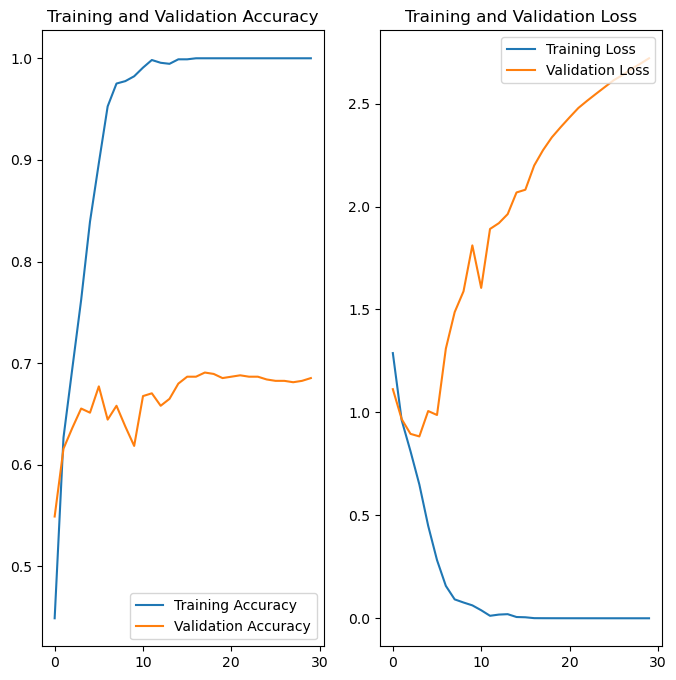

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Predict on new data**

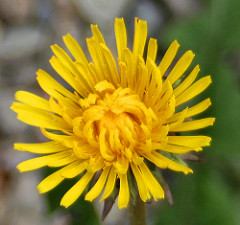

In [20]:
imageName = "./flower_photos/dandelion/451965300_619b781dc9_m.jpg"
PIL.Image.open(imageName)

In [ ]:
#print("PRE_TRAINED MODEL IS USED..!!")
#This model gives better accuracy and recognise character 
#model = load_model('./flower.h5', compile = True)

In [21]:
img = tf.keras.utils.load_img(
    imageName, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)
flowerType = class_names[np.argmax(score)]

1/1 [==============================] - 0s 265ms/step


In [22]:
print("Predicted image is :: " + class_names[np.argmax(score)])

Predicted image is :: dandelion
